# Vision artificielle et traitements des images

Ce notebook présente l'utilisation du modèle DenseNet121 pour classer les images de notre dataset. Il est possible de ne pas lancer l'entrainement du modèle et de charger le modèle pré-entrainé sur notre dataset qui se nomme "densenet_ourdata.pth". 

## Fine tuning de DenseNet121 avec notre dataset

Notre dataset contient les classes : 
- bouteilles
- canettes
- autres 
- vides

### Pré-traitement des données

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import os
from torchvision import transforms

# Dataset personnalisé sans transformation
class CustomImageDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.class_map = {"autres": 0, "bottle": 1, "canette": 2, "vide": 3}  # Labels numériques

        for class_name, label in self.class_map.items():
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):  # Vérifier que le dossier existe
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_name.lower().endswith(("png", "jpg", "jpeg")):  # Filtrer les images
                        self.image_paths.append(img_path)
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Charger l'image en couleur
        label = self.labels[idx]
        return image, label  # Retourne une image PIL et un label

# Création du dataset brut
dataset = CustomImageDataset(root_dir="data")

In [6]:
# Séparation en train/test (80% train, 10% validation, 10% test)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [7]:
# Transformation des données 

# Transformations spécifiques pour DenseNet121
densenet121_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Taille requise par DenseNet121
    transforms.ToTensor(),  # Conversion en tenseur PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
])

# Appliquer les transformations avec un `collate_fn`
def collate_fn(batch):
    images, labels = zip(*batch)  # Séparer images et labels
    images = [densenet121_transform(img) for img in images]  # Appliquer transformation
    return torch.stack(images), torch.tensor(labels)

# DataLoaders avec batch_size=32
train_loader_densenet121 = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader_densenet121 = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader_densenet121 = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Vérification du DataLoader
images, labels = next(iter(train_loader_densenet121))
print(f"Batch de {len(images)} images chargé avec taille {images.shape}")

Batch de 32 images chargé avec taille torch.Size([32, 3, 224, 224])


### Modèle DenseNet121 pré-entrainé

In [8]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

In [15]:
# Charger le modèle DenseNet121 pré-entraîné
model = models.densenet121(pretrained=True)

# Modifier la dernière couche pour correspondre à notre nombre de classes (2: "bottle" et "canette")
model.classifier = nn.Linear(model.classifier.in_features, 4)  # 2 classes

# Déplacer le modèle sur le bon appareil (GPU si disponible, sinon CPU)
device = torch.device("cpu")
model = model.to(device)

/home/am/UQAC/VA/va-env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/am/UQAC/VA/va-env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

### Entrainement

Il est possible de sauter la partie entrainement et de récupérer le modèle déjà entrainé par la suite. 

In [17]:
# Entrainement avec affichage de la perte et de la précision

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
    return train_losses, val_losses, train_accuracies, val_accuracies

# Affichage des courbes de perte et de précision
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    # Perte
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Précision
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.show()


Epoch [1/10], Train Loss: 1.0534, Train Accuracy: 53.59%
Validation Loss: 1.0042, Validation Accuracy: 52.08%
Epoch [2/10], Train Loss: 0.6609, Train Accuracy: 90.00%
Validation Loss: 0.6881, Validation Accuracy: 81.25%
Epoch [3/10], Train Loss: 0.4596, Train Accuracy: 94.62%
Validation Loss: 0.4980, Validation Accuracy: 89.58%
Epoch [4/10], Train Loss: 0.3070, Train Accuracy: 99.23%
Validation Loss: 0.2802, Validation Accuracy: 97.92%
Epoch [5/10], Train Loss: 0.2548, Train Accuracy: 98.46%
Validation Loss: 0.2303, Validation Accuracy: 97.92%
Epoch [6/10], Train Loss: 0.2192, Train Accuracy: 99.23%
Validation Loss: 0.1832, Validation Accuracy: 100.00%
Epoch [7/10], Train Loss: 0.2062, Train Accuracy: 99.23%
Validation Loss: 0.1523, Validation Accuracy: 100.00%
Epoch [8/10], Train Loss: 0.1743, Train Accuracy: 99.49%
Validation Loss: 0.1354, Validation Accuracy: 100.00%
Epoch [9/10], Train Loss: 0.1568, Train Accuracy: 99.23%
Validation Loss: 0.1117, Validation Accuracy: 100.00%
Epoch 

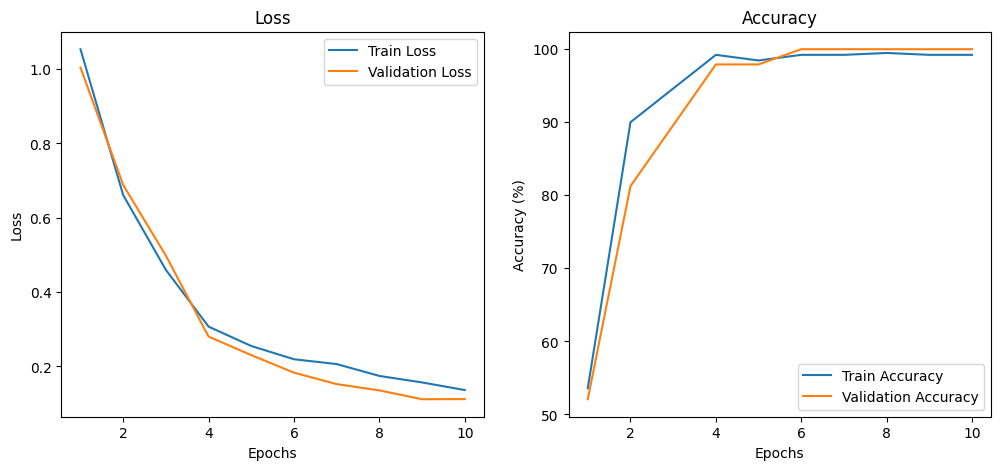

In [18]:
# Entraîner le modèle
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model,
    train_loader_densenet121,
    val_loader_densenet121,
    criterion,
    optimizer,
    num_epochs=10
)
# Afficher les courbes de perte et de précision
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

In [ ]:
# Sauvegarder le modele
torch.save(model.state_dict(), "densenet_ourdata.pth")

### Récupération du modèle pré-entrainé

In [ ]:
# Charger le modèle 
model = models.densenet121(pretrained=False)
model.classifier = nn.Linear(model.classifier.in_features, 4)  # 2 classes
model.load_state_dict(torch.load("densenet_ourdata.pth"))

### Evaluation

In [19]:
# Évaluation du modèle sur le jeu de test

def evaluate_model(model, test_loader):
    with torch.no_grad():
        model.eval()
        correct = 0
        total = 0
        test_loss = 0.0

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss /= len(test_loader)
        accuracy = 100 * correct / total
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

In [20]:
# Évaluer le modèle
evaluate_model(model, test_loader_densenet121)

Test Loss: 0.1274, Test Accuracy: 98.00%


Les résultats sont plutôt bon avec notre jeu de données. Cependant, notre jeu de données n'est pas assez complet pour garantir que le modèle sera resistant à des changements. De plus, une accuracy de 98% n'est peut être pas suffisante pour notre application. 